# Use NLI model on Autogestion dataset (V1)

The V1 model use the generated dataset before March 2023. The sentences are poorly splitted to learn.

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

In [2]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation



In [3]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [4]:
# CHECK GPU hardware

!nvidia-smi

Thu Jun  8 15:42:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:5E:00.0 Off |                  Off |
| 30%   26C    P8    16W / 230W |      0MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Loading trained model

In [5]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v1')
dm.prepare_data()
dm.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'v1/run=6_vector=0_lentropy=0.01'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

08-06-2023 15:42:51 |     INFO   archival_module.py:prepare_data:102  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/v1/vocab.pt
08-06-2023 15:42:51 |     INFO   archival_module.py:prepare_data:104  Vocab size: 12639
08-06-2023 15:42:51 |     INFO   dataset.py:__init__:86  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v1/test.json
08-06-2023 15:42:52 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
Model is in cuda:  True


# Evaluation in generated test set

## Model's predictions

### Evaluate accuracy

In [7]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.6830, device='cuda:0')

### Precision / Recall curve 

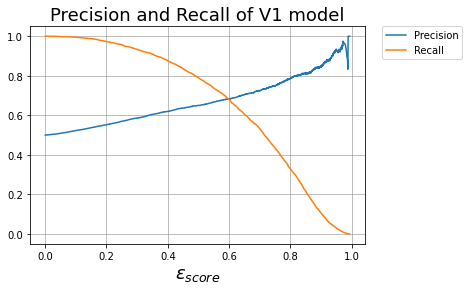

In [8]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall of V1 model', fontsize=18)
plt.show()

### How is prediction probability distributed ?

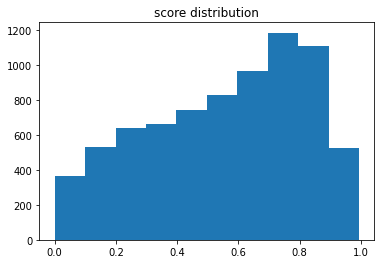

In [10]:
y_score = all_y_hat.cpu().numpy()

plt.hist(y_score) 
plt.title("score distribution") 
plt.show()

## Model's attention map

In [12]:
import pandas as pd

df_inference = pd.DataFrame()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    padding_mask = batch['padding_mask']
    B = len(y_true)
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise.ids'].to(device), 
            hypothesis_ids=batch['hypothesis.ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {side: a_hat[side].softmax(-1) for side in a_hat}
    a_hat = { side : [ attention[i][~padding_mask[side][i]].tolist()  for i in range(B) ] for side, attention in a_hat.items() }

    inferench_batch = {}
    for side in ['premise', 'hypothesis']:
        COLUMNS = [side + '.norm', side + '.form']
        inferench_batch.update({c : batch[c] for c in COLUMNS})
        inferench_batch.update({side + '.attention' : a_hat[side]})



    inferench_batch['y_true'] = batch['y_true'].tolist()
    inferench_batch['y_score'] = y_hat.tolist()
    
    inferench_batch = pd.DataFrame(inferench_batch)
    
    df_inference = pd.concat([df_inference, inferench_batch])
    
df_inference.reset_index(drop=True, inplace=True)

In [13]:
EPSILON_Y_HAT = 0.8

df_inference['y_hat'] = df_inference['y_score'] > EPSILON_Y_HAT

df_true_positive = df_inference[df_inference['y_hat'] & df_inference['y_true']]
df_true_positive = df_true_positive.sort_values(by=['y_score'], ascending=False)
df_true_positive.reset_index(drop=True, inplace=True)

print('% True positive:', len(df_true_positive) / len(df_inference))
print('# True positive:', len(df_true_positive))

% True positive: 0.16446149775072771
# True positive: 1243


In [14]:
from modules import highlight
BEGIN = 0
END = 10    

html='<table>'
html += '<thead><tr><th>Index</th> <th>Premise</th> <th>Hypothesis</th> <th>Score</th> </tr></thead>'

for idx, row in df_true_positive[BEGIN:END].iterrows():
    
    idx = str(row.name)
    #premise = [tk['form'] for tk in s_tokens]
    premise = highlight(row['premise.form'], row['premise.attention'])

    #hypothesis = ' '.join([tk['form'] for tk in t_tokens])
    hypothesis = highlight(row['hypothesis.form'], row['hypothesis.attention'])

    score = str(round(row['y_score'], 2))
    
    html += '<tr>' + '<td>' + idx + '</td>' + '<td>' +premise + '</td>' + '<td>' + hypothesis + '</td>' + '<td>' + score + '</td>' +'</tr>'
    
html += '</table>'
display(HTML(html))

Index,Premise,Hypothesis,Score
0,"[ Proudhon ] in New politics , vol .","MERVAUD Michel , « Herzen et Proudhon » in Cahiers du",0.99
1,Une vision peu connue de la collectivisation espagnole,"« Le prolétariat et les paysans espagnols firent leur devoir en s' emparant les premiers des industries et du commerce , et les autres des terres .",0.99
2,L' ORGANISATION DE LA GESTION DANS LES USINES ET LES TERRES AUTOGEREES,"Dès le début , dans les usines sont élus des Comités Révolutionnaires , ou Comités de Contrôle , parfois",0.99
3,ENSEIGNEMENTS DE L' AUTOGESTION ESPAGNOLE 149,"CNT.-U.G.T. Un embryon d' insurrection éclata , les bourgs de Moncada , Gandia , Utiel se mirent en grève et coupêrent les routes .",0.99
4,"Le comité de gestion statue , en vertu des conclusions et des lignes générales du conseil ouvrier , sur le fonctionnement de l' entreprise ( organisation du travail ) , conformément à la loi et aux statuts de l' entreprise .",Le comité de gestion comprend entre trois et onze membres .,0.99
5,"Fourier , L' Ordre Subversif , éd .","L' Emile , cité par J. R. Schmid , Le Maître Camarade et la Pédagogie Libertaire , éd .",0.99
6,— Le conseil des travailleurs est l' organe exécutif élu par l' assemblée générale .,"— Le comité de gestion , recruté au sein du conseil des travailleurs , est chargé des tâches journalières .",0.99
7,"Du monopole et par le monopole naît « la propriété impersonnelle , la pire des propriétés » , celle « des grandes compagnies anonymes ( Contr .",« La propriété - corporation » est la plus insociable .,0.99
8,tition du revenu de l' entreprise .,Les présidents des deux comités peuvent représenter l' entreprise devant les autorités administratives ou judiciaires en cas de litige avec le directeur .,0.98
9,"très favorablement 31,0 % 37,0 % 34,0 % 18,4 % positivement mais","avec des réserves 17,2 % 17,4 % 19,3 % 10,9 % j' attends ce qui va",0.98


Words received most of attention weight

In [15]:
import numpy as np
import json

ATTENDED_TOKEN_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions', 'words_attention_mass.json')

if path.exists(ATTENDED_TOKEN_PATH):
    
    # Load the attention mass if the file exits
    with open(ATTENDED_TOKEN_PATH, 'r') as f:
        avg_attention_mass = json.load(f)
else:

    # flatten and align tokens and attentions
    tokens = np.concatenate(df_true_positive['premise.norm'].tolist()).tolist()
    attentions = np.concatenate(df_true_positive['premise.attention'].tolist()).tolist()
    assert len(tokens) == len(attentions), 'Not compatible length'

    # cumulate attention weights
    attention_mass = {}
    word_occurence = {}
    for w, a in zip(tokens, attentions):
        # w : word
        # a : attention weight
        attention_mass[w] = attention_mass.get(w, 0) + a
        word_occurence[w] = word_occurence.get(w, 0) + 1

    # renormalized by the word frequency 
    avg_attention_mass = {w : attention_mass[w]/word_occurence[w] for w in attention_mass}
        
    # sort by descending order
    avg_attention_mass = {k: v for k, v in sorted(avg_attention_mass.items(), key=lambda item: -item[1])}

    # Save to file
    with open(ATTENDED_TOKEN_PATH, 'w') as f:
        json.dump(avg_attention_mass, f)

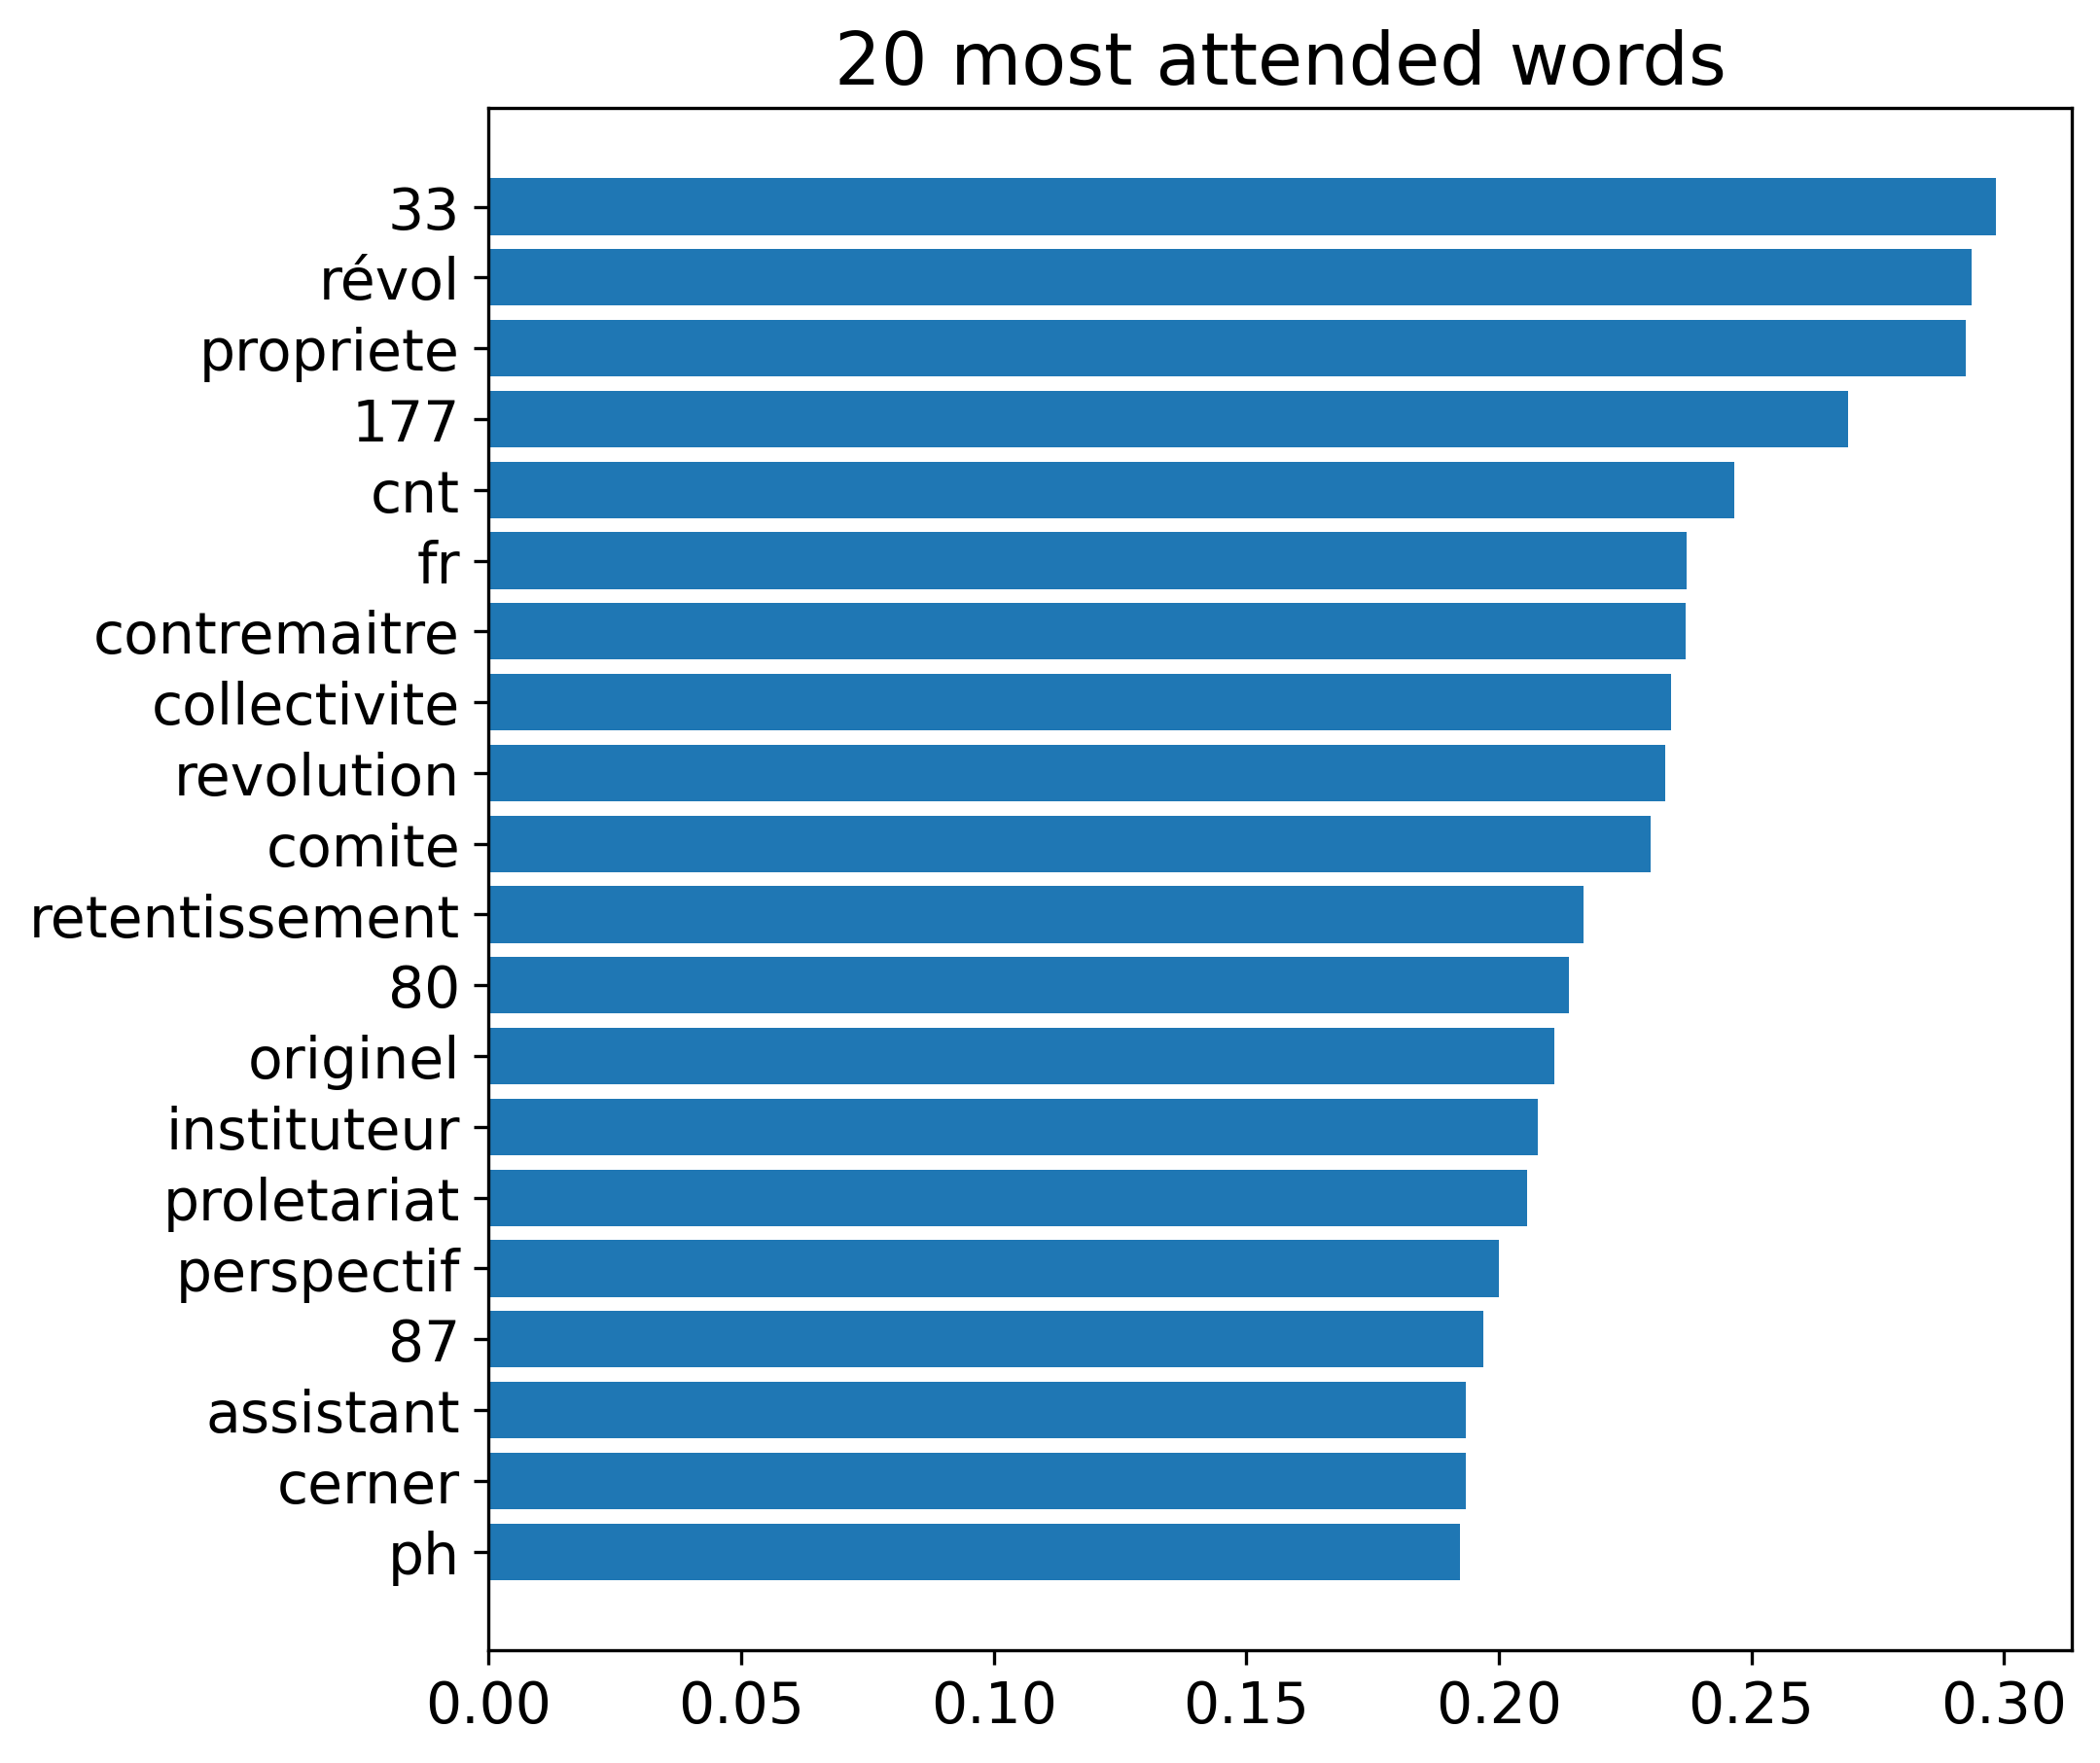

In [17]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)
plt.rcParams['figure.dpi'] = 300

N_WORDS = 20
x = list(avg_attention_mass.keys())[:N_WORDS]
y = list(avg_attention_mass.values())[:N_WORDS]
plt.barh(x[::-1], y[::-1])

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(f'{N_WORDS} most attended words', fontsize=18)

fig_path = path.join(tmp_path, 'figures')
os.makedirs(fig_path, exist_ok=True)
plt.savefig(path.join(fig_path, f'average_attn_mass_xnli.png'),dpi=100)
plt.show()

# Evaluation in Autogestion : using study subset

In [6]:
%%time
import pandas as pd

std_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'std_block_links.json')
df_std_block_links = pd.read_json(std_block_links_path, dtype={'link.type':'category'})

block_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'blocks.v2.json')
df_block = pd.read_json(block_path, encoding='utf-8')

CPU times: user 5.17 s, sys: 1.49 s, total: 6.66 s
Wall time: 6.63 s


In [8]:
article_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'articles.v2.json')
df_article = pd.read_json(article_path)
df_article.set_index('id', inplace=True)

In [11]:
# Format df_block , create uid index for easy access
df_block['uid'] = df_block['page.id.fmsh'] + '_' + df_block['bloc.id'].astype(str).str.zfill(2)
df_block = df_block.set_index('uid')

In [12]:
from modules.archival import *
from modules import *


## Study on an example link

In [13]:
#Get a link
link = df_std_block_links.iloc[1000]

source_revue_id = link['source.revue.id.persee']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.bloc.id']

# get uid
block_uid = { side: link[f'{side}.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)

In [14]:
# Prepare the tokens
block_words = {'source': [], 'target': []}
for side in block_words:
    block_form = get_block(df_block, block_uid[side], 'form')
    block_space = [[(' ' if s else '') for s in sent_s] for sent_s in get_block(df_block, block_uid[side], 'space_after')]
    block_words[side] = [[f+s for f, s in zip(block_f, block_s)] for block_f, block_s in zip(block_form, block_space)]

Heat map of how each pairs is formed

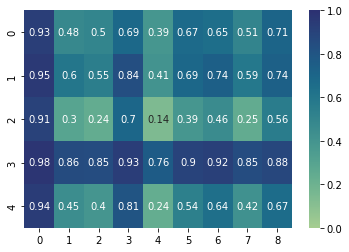

In [15]:
import seaborn as sns
from matplotlib import pyplot as plt

y_score_matrix = inference['y_score_matrix']
ax = sns.heatmap(y_score_matrix, annot=True, vmin=0, vmax=1, cmap="crest")

plt.show()

Inference sentences found

In [125]:
# get top sentence pairs for better interpretation
inference_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=10, above_threshold=0.8)

html = '<table>'
html += f'<caption><strong>{len(inference_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'

for pairs in inference_pairs:
    
    html += '<tr>'
    #tokens = pairs['pair_token']
    #attention = pairs['pair_attention']
    #html += '<td>'+ highlight(tokens, attention) +'</td>'
    source_words = block_words['source'][pairs['idx_sent_source']]
    target_words = block_words['target'][pairs['idx_sent_target']]
    
    source_words = highlight(source_words, pairs['attention_source'])
    target_words = highlight(target_words, pairs['attention_target'])
    
    html += '<td>'+ source_words + ' '+ '<u>' + target_words + '</u>' +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

aggregation result

In [138]:
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.8)

def article_identity(df_article, article_id):
    """Reformat identity for article"""
    authors = df_article.loc[article_id,'authors']
    if len(authors) == 1:
        authors = authors[0]
    else:
        ', '.join(authors)
    year = df_article.loc[article_id,'publicationYear'].astype(str)
    title = df_article.loc[article_id,'title']
    return authors + '. ' + year + '. "' +  title + '"'

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'

source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
source_identity = article_identity(df_article, source_article_id)
target_identity = article_identity(df_article, target_article_id)

html += '<thead><tr><th>Source : '+source_identity+'</th> <th>Target : '+target_identity+'</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'


# Prepare the tokens
flat_block_words = {
    side : [token for sentence in block_words[side] for token in sentence] for side in block_words
}

flat_block_attention = { 
    side: [att for sentence in block_attentions[side] for att in sentence] for side in block_words
}

# First line : block text + score + type
html += '<tr>'

html += '<td>'+ highlight(flat_block_words['source'], flat_block_attention['source'])+ '</td>'
html += '<td>'+ highlight(flat_block_words['target'], flat_block_attention['target'])+ '</td>'

# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

html += '</tbody>'
html += '</table>'
display(HTML(html))



## Meta study

Predition score between sentence pairs from the same block

In [1]:
df_std_block_links

NameError: name 'df_std_block_links' is not defined

# Evaluation in pre-established links

Supported loading modules

In [5]:
import pandas as pd
from modules.archival import *
from modules import highlight

Load cached data from mongoDB

In [6]:
block_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'blocks.json')
df_block = pd.read_json(block_path, encoding='utf-8')

In [ ]:
article_path = path.join(DATA_CACHE, 'archival', 'mongo_db', 'articles.json')
df_article = pd.read_json(article_path)
df_article.set_index('id', inplace=True)

Load model and data preprocessing logic for the model

In [38]:
def article_identity(df_article, article_id):
    """Reformat identity for article"""
    authors = df_article.loc[article_id,'authors']
    if len(authors) == 1:
        authors = authors[0]
    else:
        ', '.join(authors)
    year = df_article.loc[article_id,'publicationYear'].astype(str)
    title = df_article.loc[article_id,'title']
    return authors + ',' + year + ',"' +  title + '"'

## QA Links

In [14]:
############################
# LOAD PRESTABILISHED LINKS
############################
qa_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'qa_block_links.json')
df_qa_links = pd.read_json(qa_block_links_path, dtype={'link.type':'category'})
df_qa_links

,source.block.uid,target.block.uid,source.page.id,source.block.id,target.page.id,target.block.id,source.revue.id,source.article.id,target.article.id,source.question.id,target.question.id,reason.question_target,reason.question_source,reason.answer_target,reason.answer_source,reason.answer_target_stringIds,reason.answer_source_stringIds,score,link.type
0,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_067_02,FMSH_PB188a_00001_093,1,FMSH_PB188a_00001_067,2,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_886,FMSH_PB188a_00001_093_qa56_v2,FMSH_PB188a_00001_067_qa29_v2,Quel est le nom de l'entreprise capitaliste qu...,Quel est le nom de l'entreprise dirigée par Ra...,une bourgoisie,celle appelée « bureaucraticoétatiste,"[string_149, string_150]","[string_5, string_6, string_7, string_8]",0.6144,target_list_out_article
1,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_057_04,FMSH_PB188a_00001_093,1,FMSH_PB188a_00001_057,4,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,FMSH_PB188a_00001_093_qa56_v2,FMSH_PB188a_00001_057_qa2_v2,Quelles entreprises sont gouvernées par l'auto...,Quel est le nom de l'entreprise dirigée par Ra...,entreprises,celle appelée « bureaucraticoétatiste,[string_479],"[string_5, string_6, string_7, string_8]",0.6137,target_list_out_article
2,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_017_04,FMSH_PB188a_00001_093,1,FMSH_PB188a_00001_017,4,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,FMSH_PB188a_00001_093_qa56_v2,FMSH_PB188a_00001_017_qa34_v2,Quel est le nom de la constitution sociale sel...,Quel est le nom de l'entreprise dirigée par Ra...,la Société économique,celle appelée « bureaucraticoétatiste,"[string_352, string_353, string_354]","[string_5, string_6, string_7, string_8]",0.5408,target_list_out_article
3,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_055_03,FMSH_PB188a_00001_093,1,FMSH_PB188a_00001_055,3,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,FMSH_PB188a_00001_093_qa56_v2,FMSH_PB188a_00001_055_qa21_v2,Quel organisme peut être créé par un gouvernem...,Quel est le nom de l'entreprise dirigée par Ra...,les conseils ouvriers,celle appelée « bureaucraticoétatiste,"[string_31, string_32, string_33]","[string_5, string_6, string_7, string_8]",0.5384,target_list_out_article
4,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_017_03,FMSH_PB188a_00001_093,1,FMSH_PB188a_00001_017,3,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,FMSH_PB188a_00001_093_qa56_v2,FMSH_PB188a_00001_017_qa1_v2,Quel est le nom de l'organisation économique g...,Quel est le nom de l'entreprise dirigée par Ra...,par la « fédération industrielle agricole,celle appelée « bureaucraticoétatiste,"[string_336, string_337, string_338, string_33...","[string_5, string_6, string_7, string_8]",0.5345,target_list_out_article
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120713,FMSH_PB188a_00008_031_04,FMSH_PB188a_22-23_250_03,FMSH_PB188a_00008_031,4,FMSH_PB188a_22-23_250,3,autog_0005-0970_1969_num_8_1,autog_0005-0970_1969_num_8_1_945,autog_0338-7259_1973_num_22_1_1100,FMSH_PB188a_00008_031_qa1_v2,FMSH_PB188a_22-23_250_qa35_v2,Quels documents se trouvent dans le « Fonds de...,Dans quels documents l'autogestion est-elle in...,Tous ces documents,dans ces documents,"[string_275, string_276, string_277]","[string_137, string_138, string_139, string_140]",0.8731,target_list_out_num
1120714,FMSH_PB188a_00008_031_04,FMSH_PB188a_00003_061_02,FMSH_PB188a_00008_031,4,FMSH_PB188a_00003_061,2,autog_0005-0970_1969_num_8_1,autog_0005-0970_1969_num_8_1_945,autog_0005-0970_1967_num_3_1_908,FMSH_PB188a_00008_031_qa1_v2,FMSH_PB188a_00003_061_qa11_v2,De quels textes l'autogestion est-elle citée ?,Dans quels documents l'autogestion est-elle in...,textes,dans ces documents,[string_231],"[string_137, string_138, string_139, str

### Development

This section is dedicated to making of inference between 2 blocks

In [43]:
link = df_qa_links.iloc[500]

source_revue_id = link['source.revue.id']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.block.id']
link_type = link['link.type']

####################
# INFERENCE ON LINK
####################
# get uid
block_uid = { side: link[f'{side}.block.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.8)
# get top sentence pairs for better interpretation
top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)

html = '<table><thead><tr><th>Block source</th> <th>Block target</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'
html += '<tr>'

block_form = get_block(df_block, block_uid['source'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['source'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

block_form = get_block(df_block, block_uid['target'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['target'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

html += '<td>'+ ranking_output['type'] +'</td>'

html += '</tr>'
    
html += '</tbody></table>'
display(HTML(html))

html = '<table><thead><tr><th>Sentence pairs</th> <th>Score</th> </tr></thead>'
html += '<tbody>'
for pairs in top_sentence_pairs:
    
    if pairs['y_score'] < 0.8 : continue
    
    html += '<tr>'
    tokens = pairs['pair_token']
    attention = pairs['pair_attention']
    html += '<td>'+ highlight(tokens, attention) +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))


print('QA source:')
print(link['reason.question_source'], link['reason.answer_source'])
print('QA target:')
print(link['reason.question_target'], link['reason.answer_target'])

QA source:
A quoi doit s'adapter la structure de la Ligue ? aux conditions dans lesquelles les travailleurs décident directement de leur travail et des fruits de ce dernier
QA target:
Que peuvent changer les comités ouvriers ? de substance


In [10]:
# Note : 

link = df_qa_links.iloc[1000]

# the $review$ folder can be infered from source block.uid by accessing to revue.id.persee
source_revue_id = link['source.revue.id']
print(source_revue_id) 
source_revue_id_persee = df_block.loc[link['source.block.uid'], 'revue.id.persee']
print(source_revue_id_persee)

# the $article$ folder can be infered from source block.uid by accessing to article.id
source_article_id = link['source.article.id']
print(source_article_id) 
source_article_id = df_block.loc[link['source.block.uid'], 'article.id']
print(source_article_id) 


autog_0005-0970_1966_num_1_1
autog_0005-0970_1966_num_1_1
autog_0005-0970_1966_num_1_1_891
autog_0005-0970_1966_num_1_1_891


Code logic : 

```
For all pages :
    
    Get the page_path to json
        
    If the page has generated json, then skip

    Get all the block links in this page , make all inference and accumulate the results in a dictionary
    flush the dictionary to json
```

In [31]:
import json
from tqdm.auto import tqdm

# List all possible page
pages = df_qa_links['source.page.id'].unique()
print('# pages in total : ', len(pages))

# Browse all pages
for source_page_id in tqdm(pages, desc='Making links inference', total=len(pages), leave=False, unit='pages'):

    # Prepare the page_path : where to output the page.json that store the inference explanation
    ## Get `revue_id` and `article_id` to find the page path to save JSON file
    revue_id = df_block[df_block['page.id'] == source_page_id]['revue.id.persee'].unique()
    assert len(revue_id) < 2 , 'More than one revue id for a page'
    if len(revue_id) == 0:
        log.warning(f'Page {source_page_id} has no revue id')
        continue
    source_revue_id = revue_id[0]
    
    article_id = df_block[df_block['page.id'] == source_page_id]['article.id'].unique()
    assert len(article_id) < 2 , 'More than one article id for a page'
    source_article_id = article_id[0]
    
    ## prepare the path
    os.makedirs(path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_inference'), exist_ok=True)
    page_path = path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_inference', source_page_id + '.json')

    ## prepare the statistics path store extra information
    debug_path = path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_inference', source_page_id + '.meta.json')
    meta = {
        'cnt_block_uid_not_found': 0,
        'block_uid_not_found': [],
        'link_block_invalid': [],
    }

    # Skip if already processed
    if path.exists(page_path):
        print(f'Page {source_page_id} already processed')
        continue

    # List all links corresponding to the page
    sublink_source_page = df_qa_links[df_qa_links['source.page.id'] == source_page_id]
    textBlockList = []

    # The page is constituted of several blocks
    for source_block_id in sublink_source_page['source.block.id'].unique():
        
        # Each block has a list of links
        text_block_list_item = {
            'id' : 'block_' + str(source_block_id),
            'linkList': [],
        }

        # List all link for the current text block
        sublink_source_block = sublink_source_page[sublink_source_page['source.block.id'] == source_block_id]
        
        # text block is linked by several question id
        for source_question_id in sublink_source_block['source.question.id'].unique():

            # List all link for the current question id
            sublink_source_question = sublink_source_block[sublink_source_block['source.question.id'] == source_question_id]
            #question_source = sublink_source_question['question_source'].unique()
            #answer_source = sublink_source_question['answer_source'].unique()
            #answer_source_stringIds = sublink_source_question.iloc[0, 'answer_source_stringIds']

            # TODO Check if different question and different answer happens
            #assert len(question_source) == 1, 'More than one question_source for a question_id'
            #assert len(answer_source) == 1, 'More than one answer_source for a question_id'

            #question_source = question_source[0]
            #answer_source = answer_source[0]

            link_list_item = {
                'source_question_id' : source_question_id,
                #'question_source' : question_source,
                #'answer_source' : answer_source,
                #'answer_source_stringIds' : answer_source_stringIds
            }

            # list all possible link types for this source question
            all_types = sublink_source_question["link.type"].unique()

            for link_type in all_types:
            
                sublink_by_type = sublink_source_question[sublink_source_question['link.type'] == link_type]

                for idx_link, link in sublink_by_type.iterrows():

                    ####################
                    # INFERENCE ON LINK
                    ####################
                    try:

                        # get uid
                        block_uid = { side: link[f'{side}.block.uid'] for side in ['source', 'target']}

                        # get token 'norm' (aka. normalized tokens for model)
                        block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
                        # batched inference from gpu model
                        inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
                        # aggregate score to form a ranking score + interpretation
                        ranking_output = ranking_score(inference)
                        # aggregate attention maps
                        block_attentions = aggegrate_attention(inference, aggregation='topk', k=3)
                        # get alto ids
                        attention_alto_ids = {}
                        for side in ['source', 'target']:
                            block_alto_ids = get_block(df_block, block_uid[side], 'alto_id')
                            attention_alto_ids[side] = extract_string_id(block_alto_ids, block_attentions[side])
                    
                        # get top sentence pairs for better interpretation
                        top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)


                        link_list_item[link_type] = [
                            {
                                'target_question_id' : target_block['target.question.id'],
                                'articleId' : target_block['target.article.id'],
                                'pageId' : target_block['target.page.id'],
                                'blockId' : 'block_' + str(target_block['target.block.id']),
                                'reason_question' : {
                                    'question_target' : target_block['reason.question_target'],
                                    'answer_target' : target_block['reason.answer_target'],
                                    'score' : target_block['score'],
                                },
                                'reason_inference' : {
                                    'score' : ranking_output['ranking_score'],
                                    'aggregated_type' : ranking_output['type'],
                                    'aggregated_attention' : attention_alto_ids,
                                    'top_sentence_pairs' : top_sentence_pairs,
                                }

                            } for _, target_block in sublink_source_question.iterrows()

                        ]

                    except KeyError as e:
                        meta['cnt_block_uid_not_found'] += 1
                        meta['block_uid_not_found'].append(block_uid)
                        meta['link_block_invalid'].append({
                            'source_block': link['source.block.uid'],
                            'target_block': link['target.block.uid'],
                        })

            text_block_list_item['linkList'].append(link_list_item)
        textBlockList.append(text_block_list_item)

    content = {
        'method' : 'links_inference',
        'quetsion_page_source_id' : source_page_id,
        'question_article_source_id' : source_article_id,
        'page': {
            'textBlockList' : textBlockList   
        }
    }

    with open(page_path, 'w') as f:
        json.dump(content, f, indent=4, ensure_ascii=False)
    
    with open(debug_path, 'w') as f:
        json.dump(meta, f, indent=4, ensure_ascii=False)
    

# pages in total :  4557


Making links inference:   0%|          | 0/4557 [00:00<?, ?pages/s]

Page FMSH_PB188a_00001_093 already processed
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_116 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_141 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_120 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_136 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_137 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_121 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_140 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_117 has no revue id
28-04-2023 16:51:46 |  WARNING   223639378.py:<cell line: 9>:16  Page FMSH_PB188a_26-27_126

### Generate output files to mongo db


## Similarity Links

In [ ]:
############################
# LOAD PRESTABILISHED LINKS
############################
sim_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'similarity_block_links.json')
df_sim_links = pd.read_json(sim_block_links_path)

# add revue id
df_sim_links = pd.merge(df_sim_links, df_block[['revue.id.persee']], left_on=["source.block.uid"], right_on=["uid"])
df_sim_links.rename(columns={'revue.id.persee': 'source.revue.id'}, inplace=True)

df_sim_links = pd.merge(df_sim_links, df_block[['revue.id.persee']], left_on=["target.block.uid"], right_on=["uid"])
df_sim_links.rename(columns={'revue.id.persee': 'target.revue.id'}, inplace=True)

df_sim_links.head(3)

In [10]:
sim_block_links_path = path.join(DATA_CACHE, 'archival', 'block_link', 'similarity_block_links.json')
df_sim_links = pd.read_json(sim_block_links_path)

In [11]:
df_sim_links

,source.block.uid,target.block.uid,source.article.id,source.page.id,source.block.id,target.article.id,target.page.id,target.block.id,reason.score,link.type
0,FMSH_PB188a_00001_094_01,FMSH_PB188a_00001_094_02,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_094,1,autog_0005-0970_1966_num_1_1_891,FMSH_PB188a_00001_094,2,0.4414,target_list_out_article
1,FMSH_PB188a_00001_094_01,FMSH_PB188a_00001_091_05,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_094,1,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_091,5,0.3370,target_list_in
2,FMSH_PB188a_00001_094_01,FMSH_PB188a_33-34_146_07,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_094,1,autog_0338-7259_1976_num_33_1_1163,FMSH_PB188a_33-34_146,7,0.5069,target_list_out_num
3,FMSH_PB188a_00001_094_02,FMSH_PB188a_00001_090_05,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_094,2,autog_0005-0970_1966_num_1_1_889,FMSH_PB188a_00001_090,5,0.5456,target_list_out_article
4,FMSH_PB188a_00001_094_02,FMSH_PB188a_00001_090_01,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_094,2,autog_0005-0970_1966_num_1_1_890,FMSH_PB188a_00001_090,1,0.4742,target_list_in
...,...,...,...,...,...,...,...,...,...,...
132817,autog_0249-2563_1983_num_16_14_T1_0002_0000_07,autog_0249-2563_1983_num_16_14_T1_0070_0000_04,autog_0249-2563_1983_num_16_14_1961,autog_0249-2563_1983_num_16_14_T1_0002_0000,7,autog_0249-2563_1983_num_16_14_1560,autog_0249-2563_1983_num_16_14_T1_0070_0000,4,0.2394,target_list_out_article
132818,autog_0249-2563_1983_num_16_14_T1_0002_0000_07,autog_0249-2563_1982_num_15_10_T1_0002_0000_10,autog_0249-2563_1983_num_16_14_1961,autog_0249-2563_1983_num_16_14_T1_0002_0000,7,autog_0249-2563_1982_num_15_10_1959,autog_0249-2563_1982_num_15_10_T1_0002_0000,10,0.8703,target_list_out_num
132819,autog_0249-2563_1983_num_16_14_T1_0001_0000_04,autog_0249-2563_1983_num_16_14_T1_0082_0000_01,autog_0249-2563_1983_num_16_14_1961,autog_0249-2563_1983_num_16_14_T1_0001_0000,4,autog_0249-2563_1983_num_16_14_1562,autog_0249-2563_1983_num_16_14_T1_0082_0000,1,0.4701,target_list_out_article
132820,autog_0249-2563_1983_num_16_14_T1_0001_0000_04,autog_0249-2563_1983_num_16_14_T1_0082_0000_01,autog_0249-2563_1983_num_16_14_1961,autog_0249-2563_1983_num_16_14_T1_0001_0000,4,autog_0249-2563_1983_num_16_14_1562,autog_0249-2563_1983_num_16_14_T1_0082_0000,1,0.4701,target_list_out_article


### Development

This section is dedicated to making of inference between 2 blocks

In [ ]:
%%time

link = df_sim_links.iloc[1000]

source_revue_id = link['source.revue.id']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.block.id']
link_type = link['link.type']

####################
# INFERENCE ON LINK
####################
# get uid
block_uid = { side: link[f'{side}.block.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)


# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.8)

# get top sentence pairs for better interpretation
top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'
html += '<thead><tr><th>Block source</th> <th>Block target</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'

# First line : block text + score + type
html += '<tr>'

# source
block_form = get_block(df_block, block_uid['source'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['source'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

# target
block_form = get_block(df_block, block_uid['target'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['target'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'
# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'
# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

# First line : block text + score + type
html += '<tr>'
source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
html += '<td><i>'+ article_identity(df_article, source_article_id) + '</i></td><td><i>'+ article_identity(df_article, target_article_id) + '</i></td>'
html += '<td></td><td></td>'
html += '</tr>'


html += '</tbody>'
html += '</table>'
display(HTML(html))

html = '<table>'
html += f'<caption><strong>{len(top_sentence_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'
for pairs in top_sentence_pairs:
    html += '<tr>'
    tokens = pairs['pair_token']
    attention = pairs['pair_attention']
    html += '<td>'+ highlight(tokens, attention) +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

In [31]:
# Testing

link = df_sim_links.iloc[950]

source_revue_id = link['source.revue.id']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.block.id']
link_type = link['link.type']

####################
# INFERENCE ON LINK
####################
# get uid
block_uid = { side: link[f'{side}.block.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)


# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', k=3, epsilon=0.8)

# get top sentence pairs for better interpretation
top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)

html = '<table>'
html += f'<caption><strong>Explanation between the 2 textblocks</strong></caption>'
html += '<thead><tr><th>Block source</th> <th>Block target</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'

# First line : block text + score + type
html += '<tr>'

# source
block_form = get_block(df_block, block_uid['source'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['source'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

# target
block_form = get_block(df_block, block_uid['target'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['target'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'
# score
html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'
# type
html += '<td>'+ ranking_output['type'] +'</td>'
html += '</tr>'

# First line : block text + score + type
html += '<tr>'
source_article_id = link['source.article.id']
target_article_id = link['target.article.id']
html += '<td><i>'+ article_identity(df_article, source_article_id) + '</i></td><td><i>'+ article_identity(df_article, target_article_id) + '</i></td>'
html += '<td></td><td></td>'
html += '</tr>'


html += '</tbody>'
html += '</table>'
display(HTML(html))

html = '<table>'
html += f'<caption><strong>{len(top_sentence_pairs)} entailment(s) found</strong></caption>'
html += '<thead><tr><th>Sentence</th> <th>Score</th> </tr></thead>'
html += '<tbody>'
for pairs in top_sentence_pairs:
    html += '<tr>'
    tokens = pairs['pair_token']
    attention = pairs['pair_attention']
    html += '<td>'+ highlight(tokens, attention) +'</td>'
    html += '<td>'+ str(round(pairs['y_score'],2)) +'</td>'
    html += '</tr>'

display(HTML(html))

with k tensor([[1., 1.],
        [0., 1.]])
with epsilon tensor([[1., 1.],
        [0., 1.]])


In [51]:
import json
from tqdm.auto import tqdm

# List all possible page
pages = df_sim_links['source.page.id'].unique()
print('# pages in total : ', len(pages))

# Browse all pages
for source_page_id in tqdm(pages, desc='Making links inference', total=len(pages), leave=False, unit='pages'):

    # Prepare the page_path : where to output the page.json that store the inference explanation
    ## Get `revue_id` and `article_id` to find the page path to save JSON file
    revue_id = df_block[df_block['page.id'] == source_page_id]['revue.id.persee'].unique()
    assert len(revue_id) < 2 , 'More than one revue id for a page'
    if len(revue_id) == 0:
        log.warning(f'Page {source_page_id} has no revue id')
        continue
    source_revue_id = revue_id[0]
    
    article_id = df_block[df_block['page.id'] == source_page_id]['article.id'].unique()
    assert len(article_id) < 2 , 'More than one article id for a page'
    source_article_id = article_id[0]
    
    ## prepare the path
    os.makedirs(path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_similarity_inference'), exist_ok=True)
    page_path = path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_similarity_inference', source_page_id + '.json')

    ## prepare the statistics path store extra information
    debug_path = path.join(SERVER_DIR, 'autogestion', source_revue_id, source_article_id, 'links_similarity_inference', source_page_id + '.meta.json')
    meta = {
        'cnt_block_uid_not_found': 0,
        'block_uid_not_found': [],
        'link_block_invalid': [],
        'aggregated_type': {
            'neutral' : 0,
            'row' : 0,
            'column' : 0,
            'dense': 0,
        }
    }

    # Skip if already processed
    if path.exists(page_path):
        print(f'Page {source_page_id} already processed:')
        print(page_path)
        #continue

    # List all links corresponding to the page
    sublink_source_page = df_sim_links[df_sim_links['source.page.id'] == source_page_id]
    textBlockList = []

    # The page is constituted of several blocks
    for source_block_id in sublink_source_page['source.block.id'].unique():
        
        # Each block has a list of links
        text_block_list_item = {
            'id' : 'block_' + str(source_block_id),
            'linkList': [],
        }

        # List all link for the current text block
        sublink_source_block = sublink_source_page[sublink_source_page['source.block.id'] == source_block_id]
        
        link_list_item = {
            'source_textblock_id' : source_article_id + '|' + source_page_id + '|block_' + str(source_block_id),
        }

        # list all possible link types for this source question
        all_types = sublink_source_block["link.type"].unique()

        for link_type in all_types:

            sublink_by_type = sublink_source_block[sublink_source_block['link.type'] == link_type]
            for idx_link, link in sublink_by_type.iterrows():

                ####################
                # INFERENCE ON LINK
                ####################
                try:

                    # get uid
                    block_uid = { side: link[f'{side}.block.uid'] for side in ['source', 'target']}

                    # get token 'norm' (aka. normalized tokens for model)
                    block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
                    # batched inference from gpu model
                    inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
                    # aggregate score to form a ranking score + interpretation
                    ranking_output = ranking_score(inference)
                    # aggregate attention maps
                    block_attentions = aggegrate_attention(inference, aggregation='topk', k=3)
                    # get alto ids
                    attention_alto_ids = {}
                    for side in ['source', 'target']:
                        block_alto_ids = get_block(df_block, block_uid[side], 'alto_id')
                        attention_alto_ids[side] = extract_string_id(block_alto_ids, block_attentions[side])

                    # get top sentence pairs for better interpretation
                    top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)

                    link_list_item[link_type] = [
                        {
                            'target_textblock_id' : target_block['target.article.id'] + '|' + target_block['target.page.id'] + '|block_' + str(target_block['target.block.id']) ,
                            'articleId' : target_block['target.article.id'],
                            'pageId' : target_block['target.page.id'],
                            'blockId' : 'block_' + str(target_block['target.block.id']),
                            'reason_similarity' : {
                                'score' : target_block['reason.score'],
                            },
                            'reason_inference' : {
                                'score' : ranking_output['ranking_score'],
                                'aggregated_type' : ranking_output['type'],
                                'aggregated_attention' : attention_alto_ids,
                                'top_sentence_pairs' : top_sentence_pairs,
                            }

                        } for _, target_block in sublink_by_type.iterrows()

                    ]

                    meta['aggregated_type'][ranking_output['type']] += 1
                    
                except KeyError as e:
                    print(e)
                    meta['cnt_block_uid_not_found'] += 1
                    meta['block_uid_not_found'].append(block_uid)
                    meta['link_block_invalid'].append({
                        'source_block': link['source.block.uid'],
                        'target_block': link['target.block.uid'],
                    })

            text_block_list_item['linkList'].append(link_list_item)
            
            
        textBlockList.append(text_block_list_item)
        

    content = {
        'method' : 'links_inference',
        'textblocks_page_source_id' : source_page_id,
        'textblocks_article_source_id' : source_article_id,
        'page': {
            'textBlockList' : textBlockList   
        }
    }

    with open(page_path, 'w') as f:
        json.dump(content, f, indent=4, ensure_ascii=False)
    
    with open(debug_path, 'w') as f:
        json.dump(meta, f, indent=4, ensure_ascii=False)
    

# pages in total :  8435


Making links inference:   0%|          | 0/8435 [00:00<?, ?pages/s]

NameError: name 'df_block' is not defined

### Development on the fly

In [11]:
sys.path.append('./../../archi-utils')

from archi_utils.mongo_utils import ArchivalMongoClient

c = ArchivalMongoClient(url='mongodb://193.51.124.73:27017/', username='collectionreader', password='xR5c(-EXuicqOyVLg.y@')


In [12]:
def sentenize(block_conll, feat='norm'):
    sents = []
    sent = []
    
    for token in block_conll:
        
        if feat == 'norm':
            sent.append(token['lemma'].lower())
        else:
            sent.append(token[feat])
        
        if token['form'] == '.' and token['upos'] == 'PUNCT':
            if len(sent) > 0:
                sents.append(sent)
            sent = []
    
    if len(sent) > 0:
        sents.append(sent)
            
    return sents

In [13]:
iden_keys = ('textblocks_page_source_id', 'textblocks_article_source_id')
existing_infer_sim_link = [
    {
        k: l[k] for k in iden_keys
    } for l in c.links_infer_sim_collection.find({}) 
]

In [14]:
from tqdm.notebook import tqdm
import warnings

sim_links = [l for l in c.similarity_collection.find({})]

for link in tqdm(sim_links, total=len(sim_links)):
    
    # check if already exist:
    identity = {
        'textblocks_page_source_id': link['textblocks_page_source_id'],
        'textblocks_article_source_id' : link['textblocks_article_source_id']
    }
    if identity in existing_infer_sim_link:
        continue

    link['method'] = 'similarity_inference'

    source_page_id = link['textblocks_page_source_id']

    cp = 0
    for source_textblock in link['page']['textBlockList']:
        source_block_id = source_textblock['id']
        
        try:
            
            source_block_conll = c.get_text_block(
                page_id=source_page_id,
                block_id=source_block_id,
            )
        except ValueError as e:
            print('Error occured, ',e)
            continue

        block_norm = {'source': sentenize(source_block_conll)}

        for suggested_link in source_textblock['linkList']:

            for link_type in suggested_link:
                if 'source' in link_type: continue

                for target_block in suggested_link[link_type]:

                    try:
                        target_block_conll = c.get_text_block(
                            page_id=target_block['pageId'],
                            block_id=target_block['blockId'],
                        )
                    except ValueError as e:
                        print('Error occured, ',e)
                        continue
                        

                    block_norm['target'] = sentenize(target_block_conll)

                    inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
                    # aggregate score to form a ranking score + interpretation
                    ranking_output = ranking_score(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
                    # aggregate attention maps
                    block_attentions = aggegrate_attention(inference, aggregation='topk_threshold', epsilon=0.8, k=3)
                    # TODO get top sentence pairs for better interpretation
                    #top_sentence_pairs = get_top_sentence_pairs(df_block, block_uid['source'], block_uid['target'], inference, k=3)


                    # Generate HTML
                    html = '<table>'
                    html += f'<caption><strong>Implication entre les deux paragraphes</strong></caption>'
                    html += '<thead><tr><th>Source</th> <th>Target</th> </tr></thead>'

                    html += '<tbody>'

                    html += '<tr>'

                    # source
                    block_form = sentenize(source_block_conll, 'form')
                    tokens = [token for sentence in block_form for token in sentence]
                    attention = [att for sentence in block_attentions['source'] for att in sentence]
                    html += '<td>'+ highlight(tokens, attention)+ '</td>'

                    # target
                    block_form = sentenize(target_block_conll, 'form')
                    tokens = [token for sentence in block_form for token in sentence]
                    attention = [att for sentence in block_attentions['target'] for att in sentence]
                    html += '<td>'+ highlight(tokens, attention)+ '</td>'
                    html += '</tr>'
                    html += '</tbody>'
                    html += '</table>'

                    # Put it back into dictionary
                    target_block['reason_inference'] = {
                        'html': html,
                        'score': ranking_output['ranking_score']
                    }

    c.links_infer_sim_collection.insert_one(link)



  0%|          | 0/8788 [00:00<?, ?it/s]

KeyError: 'textblocks_page_source_id'

In [12]:
sim_links = [c.links_infer_sim_collection.find({})]

In [16]:
link = c.links_infer_sim_collection\
.aggregate([{ '$sample': { 'size': 1 } }]).next()



In [34]:
for k in duplicated[0]:
    if duplicated[0][k] != duplicated[1][k]:
        print(k)

textblocks_article_source_id
page


## TF-IDF

In [1]:
1 in [1, 2]

True